## Notebook to examine degenerate core causes + effects for an AND+OR gate system

In [2]:
import pyphi
import numpy as np
import itertools
from pyphi import Direction
from pyphi import utils
from pyphi import cache
from pyphi import models

# Transition probability matrix. Saying where each state goes (little-endian notation)
tpm = np.array([
    [0.,0.],
    [0.,1.],
    [0.,1.],
    [1.,1.],
])

# Set up network object
network = pyphi.Network(tpm, node_labels=['A','B'])
print("Network = ",network.node_labels)

# Put the system into a given state
state = (0,0)
nodes = ['A','B']

## Get the requisite Subsystem
subsystem = pyphi.Subsystem(network, state, nodes)

## What does PyPhi Give?
pyphi_val = pyphi.compute.phi(subsystem)
print("PyPhi Value = ",pyphi_val)
print(pyphi.compute.sia(subsystem))


## Find all concepts for the specified subsystem
all_concepts = []
mechanisms = utils.powerset(subsystem.node_indices, nonempty=True)
for mechanism in mechanisms:
    mechanism_concepts = []
    
    # Find the CORE cause(s) for a given mechanism
    direction = Direction.CAUSE
    past_purviews = subsystem.potential_purviews(direction, mechanism, purviews=False)
    all_causes = [subsystem.find_mip(direction, mechanism, purview) for purview in past_purviews]
    core_cause = max(all_causes)
    if core_cause.phi > 0.:
        all_core_causes = [value for index,value in enumerate(subsystem.find_mip(direction, mechanism, purview) for purview in past_purviews) if value.phi == core_cause.phi]
    else:
        all_core_causes = [core_cause]
                
    # Find the CORE effect(s) for a given mechanism
    direction = Direction.EFFECT
    future_purviews = subsystem.potential_purviews(direction, mechanism, purviews=False)
    all_effects = [subsystem.find_mip(direction, mechanism, purview) for purview in future_purviews]
    core_effect = max(all_effects)
    if core_effect.phi > 0.:
        all_core_effects = [value for index,value in enumerate(subsystem.find_mip(direction, mechanism, purview) for purview in future_purviews) if value.phi == core_effect.phi]
    else:
        all_core_effects = [core_effect]
            
            
    ## Now we need to build concepts for all possible core cause and core effect combinations
    for each_cause in all_core_causes:
        MIC = models.MaximallyIrreducibleCause(each_cause)
        for each_effect in all_core_effects:
            MIE = models.MaximallyIrreducibleEffect(each_effect)
            
            concept = models.Concept(mechanism = mechanism, cause = MIC, effect = MIE, subsystem = subsystem)            
                            
            ## If phi^max > 0 store the concept
            if concept.phi > 0.:
                mechanism_concepts.append(concept)
            
    if mechanism_concepts:
        all_concepts.append(mechanism_concepts)
        

# Create all possible CES via the cartesian product of all possible concepts for each mechanism
original_CES = []
for element in itertools.product(*all_concepts):
    original_CES.append(models.CauseEffectStructure(concepts=element))
    
for CES in original_CES:
    print("Possible CES:")
    print(CES)


Network =  NodeLabels(('A', 'B'))


PyPhi Value =  0.090278


┌──────────────────────────────────────────────────────────────┐
│         System irreducibility analysis: Φ = 0.090278         │
│                     Cut [B] ━━/ /━━➤ [A]                     │
│                       Subsystem(A, B)                        │
│ ════════════════════════════════════════════════════════════ │
│             Cause-effect structure (2 concepts)              │
│ ════════════════════════════════════════════════════════════ │
│   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   │
│              Concept: Mechanism = [A], φ = 1/6               │
│   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   │
│               MIC                         MIE                │
│   ┌──────────────────────────┐┌──────────────────────────┐   │
│   │  φ = 1/6                 ││  φ = 1/4                 │   │
│   │  Purview = [A, B]        ││  Purview = [A, B]        │   │
│   │  MIP:                    ││  MIP:                    │   │
│   │     ∅     A        

In [3]:
from pyphi import compute
from pyphi import partition
from pyphi import models

## Initialize an empty list to store all Phi values for all cuts
Phi_Spectrum = []

## Get all possible cuts of the subsystem
sia_bipartitions = compute.subsystem.sia_bipartitions(subsystem.cut_indices, subsystem.cut_node_labels)

## For each cut, get all Phi values
for cut in sia_bipartitions:
    print("\nEvaluating Cut ",cut)
    new_subsystem = subsystem.apply_cut(cut)
    
    ## Find all concepts for the specified subsystem
    all_concepts = []
    mechanisms = utils.powerset(new_subsystem.node_indices, nonempty=True)
    for mechanism in mechanisms:
        mechanism_concepts = []

        # Find the CORE cause(s) for a given mechanism
        direction = Direction.CAUSE
        past_purviews = new_subsystem.potential_purviews(direction, mechanism, purviews=False)
        all_causes = [new_subsystem.find_mip(direction, mechanism, purview) for purview in past_purviews]
        core_cause = max(all_causes)        
        if core_cause.phi > 0.:
            all_core_causes = [value for index,value in enumerate(new_subsystem.find_mip(direction, mechanism, purview) for purview in past_purviews) if value.phi == core_cause.phi]
        else:
            all_core_causes = [core_cause]
            
        # Find the CORE effect(s) for a given mechanism
        direction = Direction.EFFECT
        future_purviews = new_subsystem.potential_purviews(direction, mechanism, purviews=False)
        all_effects = [new_subsystem.find_mip(direction, mechanism, purview) for purview in future_purviews]
        core_effect = max(all_effects)     
        if core_effect.phi > 0.:
            all_core_effects = [value for index,value in enumerate(new_subsystem.find_mip(direction, mechanism, purview) for purview in future_purviews) if value.phi == core_effect.phi]
        else:
            all_core_effects = [core_effect]            

        ## Now build concepts for every possible combination of core causes and effects
        for each_cause in all_core_causes:
            MIC = models.MaximallyIrreducibleCause(each_cause)
            for each_effect in all_core_effects:
                MIE = models.MaximallyIrreducibleEffect(each_effect)
                concept = models.Concept(mechanism = mechanism, cause = MIC, effect = MIE, subsystem = new_subsystem)
                
                ## If phi^max > 0 store the concept
                if concept.phi > 0.:
                    mechanism_concepts.append(concept)

        ## If the mechanism gives rise to any concepts, store them as a list
        if mechanism_concepts:
            all_concepts.append(mechanism_concepts)    
    
    # The possible CES are the cartesian product of all possible concepts for each mechanism
    new_CES = []
    for element in itertools.product(*all_concepts):
        new_CES.append(models.CauseEffectStructure(concepts=element))
        
    print(new_CES)
 
    ## Now store all possible Phi values for this cut
    Phi_cut = []
    for original in original_CES:
        for new in new_CES:
            Phi = compute.distance.ces_distance(original,new)
            print("\tPhi = ",Phi)
            Phi_cut.append(Phi)
            
    ## Append the list of Phi values to the spectrum
    Phi_Spectrum.append(Phi_cut)


Evaluating Cut  Cut [A] ━━/ /━━➤ [B]
[════════════════════════════════════════════════════════════
            Cause-effect structure (2 concepts)             
════════════════════════════════════════════════════════════
  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  
             Concept: Mechanism = [A], φ = 1/6              
  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  
              MIC                         MIE               
  ┌──────────────────────────┐┌──────────────────────────┐  
  │  φ = 1/6                 ││  φ = 1/4                 │  
  │  Purview = [A]           ││  Purview = [A]           │  
  │  MIP:                    ││  MIP:                    │  
  │     ∅     A              ││     ∅     A              │  
  │    ─── ✕ ───             ││    ─── ✕ ───             │  
  │     A     ∅              ││     A     ∅              │  
  │  Repertoire:             ││  Repertoire:             │  
  │    ┌─────────────┐       ││    ┌──────────

	Phi =  0.395833
	Phi =  0.3125
	Phi =  0.333334
	Phi =  0.451389
	Phi =  0.368056
	Phi =  0.388889
	Phi =  0.423611
	Phi =  0.340278
	Phi =  0.361111
	Phi =  0.083333
	Phi =  0.208333
	Phi =  0.145834
	Phi =  0.138889
	Phi =  0.208333
	Phi =  0.201389
	Phi =  0.111111
	Phi =  0.236111
	Phi =  0.173611
	Phi =  0.208333
	Phi =  0.083333
	Phi =  0.145834
	Phi =  0.263889
	Phi =  0.138889
	Phi =  0.201389
	Phi =  0.236111
	Phi =  0.111111
	Phi =  0.173611
	Phi =  0.145834
	Phi =  0.145834
	Phi =  0.083333
	Phi =  0.201389
	Phi =  0.201389
	Phi =  0.138889
	Phi =  0.173612
	Phi =  0.173611
	Phi =  0.111111
	Phi =  0.208333
	Phi =  0.333334
	Phi =  0.270833
	Phi =  0.263889
	Phi =  0.333334
	Phi =  0.326389
	Phi =  0.236111
	Phi =  0.305556
	Phi =  0.298611
	Phi =  0.333334
	Phi =  0.208334
	Phi =  0.270833
	Phi =  0.388889
	Phi =  0.263889
	Phi =  0.326389
	Phi =  0.361112
	Phi =  0.236111
	Phi =  0.298612
	Phi =  0.270833
	Phi =  0.270834
	Phi =  0.208334
	Phi =  0.326389
	Phi =  0.326389

	Phi =  0.173611
	Phi =  0.111111
	Phi =  0.180555
	Phi =  0.173611
	Phi =  0.083333
	Phi =  0.208333
	Phi =  0.145833
	Phi =  0.236111
	Phi =  0.111111
	Phi =  0.173612
	Phi =  0.236111
	Phi =  0.111111
	Phi =  0.173612
	Phi =  0.208333
	Phi =  0.083333
	Phi =  0.145833
	Phi =  0.173611
	Phi =  0.173611
	Phi =  0.111111
	Phi =  0.173611
	Phi =  0.173611
	Phi =  0.111111
	Phi =  0.145833
	Phi =  0.145833
	Phi =  0.083333
	Phi =  0.236111
	Phi =  0.305556
	Phi =  0.298611
	Phi =  0.236111
	Phi =  0.305556
	Phi =  0.298611
	Phi =  0.208333
	Phi =  0.277778
	Phi =  0.270833
	Phi =  0.361111
	Phi =  0.236111
	Phi =  0.298611
	Phi =  0.361111
	Phi =  0.236111
	Phi =  0.298611
	Phi =  0.333334
	Phi =  0.208333
	Phi =  0.270833
	Phi =  0.298611
	Phi =  0.298611
	Phi =  0.236111
	Phi =  0.298611
	Phi =  0.298611
	Phi =  0.236111
	Phi =  0.270833
	Phi =  0.270833
	Phi =  0.208334
	Phi =  0.263889
	Phi =  0.305556
	Phi =  0.243056
	Phi =  0.319445
	Phi =  0.361111
	Phi =  0.298611
	Phi =  0.2916

	Phi =  0.229167
	Phi =  0.104167
	Phi =  0.152778
	Phi =  0.291666
	Phi =  0.277778
	Phi =  0.125
	Phi =  0.375
	Phi =  0.25
	Phi =  0.166667
	Phi =  0.333333
	Phi =  0.291667
	Phi =  0.083333
	Phi =  0.333334
	Phi =  0.208333
	Phi =  0
	Phi =  0.25
	Phi =  0.125
	Phi =  0.041667
	Phi =  0.291667
	Phi =  0.166667
	Phi =  0.145834
	Phi =  0.3125
	Phi =  0.270834
	Phi =  0.0625
	Phi =  0.3125
	Phi =  0.1875
	Phi =  0.104167
	Phi =  0.270833
	Phi =  0.229167
	Phi =  0.291666
	Phi =  0.208333
	Phi =  0.333334
	Phi =  0.375
	Phi =  0.125
	Phi =  0.25
	Phi =  0.333333
	Phi =  0.166667
	Phi =  0.291667
	Phi =  0.333333
	Phi =  0.083333
	Phi =  0.208333
	Phi =  0.25
	Phi =  0
	Phi =  0.125
	Phi =  0.291667
	Phi =  0.041667
	Phi =  0.166667
	Phi =  0.3125
	Phi =  0.145834
	Phi =  0.270833
	Phi =  0.3125
	Phi =  0.0625
	Phi =  0.1875
	Phi =  0.270833
	Phi =  0.104167
	Phi =  0.229167
	Phi =  0.277778
	Phi =  0.333334
	Phi =  0.208333
	Phi =  0.25
	Phi =  0.25
	Phi =  0.125
	Phi =  0.291667
	Phi

	Phi =  0.361111
	Phi =  0.194445
	Phi =  0.319445
	Phi =  0.361111
	Phi =  0.111111
	Phi =  0.236111
	Phi =  0.277778
	Phi =  0.027778
	Phi =  0.152778
	Phi =  0.319445
	Phi =  0.069445
	Phi =  0.194445
	Phi =  0.340278
	Phi =  0.173611
	Phi =  0.298611
	Phi =  0.340278
	Phi =  0.090278
	Phi =  0.215278
	Phi =  0.298611
	Phi =  0.131944
	Phi =  0.256944
	Phi =  0.305556
	Phi =  0.305556
	Phi =  0.236111
	Phi =  0.277778
	Phi =  0.277778
	Phi =  0.152778
	Phi =  0.319445
	Phi =  0.319445
	Phi =  0.194445
	Phi =  0.236111
	Phi =  0.236111
	Phi =  0.111111
	Phi =  0.152778
	Phi =  0.152778
	Phi =  0.027778
	Phi =  0.194445
	Phi =  0.194445
	Phi =  0.069445
	Phi =  0.298611
	Phi =  0.298611
	Phi =  0.173611
	Phi =  0.215278
	Phi =  0.215278
	Phi =  0.090278
	Phi =  0.256945
	Phi =  0.256945
	Phi =  0.131945
	Phi =  0.194445
	Phi =  0.305556
	Phi =  0.291667
	Phi =  0.194445
	Phi =  0.388889
	Phi =  0.319445
	Phi =  0.152778
	Phi =  0.347222
	Phi =  0.277778
	Phi =  0.069445
	Phi =  0.3194

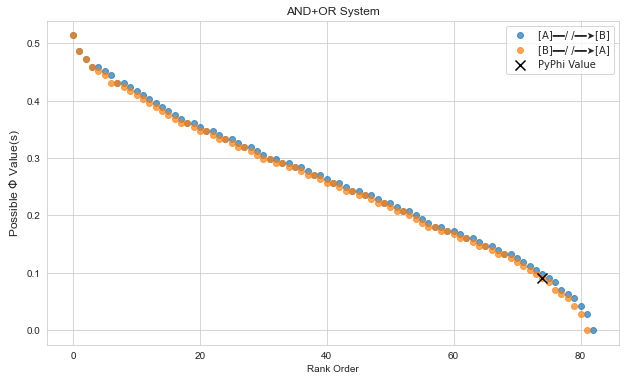

In [25]:
import matplotlib.font_manager as mfm## Choose a font that renders the cut symbol properly


# -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

## UTF Characters
LINE = "\u2501"
CUT_SYMBOL = LINE * 2 + "/ /" + LINE * 2 + "\u27A4"

## Set Font. We need a special font to render the cut symbols properly
## If you don't care about the cut symbol rendering, you can comment the font out
font_path = '/usr/local/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
font = mfm.FontProperties(fname=font_path) # find this font

## Initialize fig, ax objects
fig = plt.figure(figsize=(8.8,5.4))
ax = plt.subplot(111)

## Scatterplot Phi Values for each cut
x_labels = []
for i in range(len(Phi_Spectrum)):
    cut = sia_bipartitions[i]
    
    ## Get label for cut
    from_nodes = models.fmt.fmt_mechanism(cut.from_nodes, cut.node_labels)
    to_nodes = models.fmt.fmt_mechanism(cut.to_nodes, cut.node_labels)
    cut_label = from_nodes+CUT_SYMBOL+to_nodes
    
    sorted_values = sorted(set(Phi_Spectrum[i]),reverse=True)
    
    plt.scatter(range(len(sorted_values)),sorted_values,alpha=0.7,label=cut_label,)
#     plt.scatter([i]*len(Phi_Spectrum[i]),Phi_Spectrum[i],label=cut_label,alpha=0.5)
#     x_labels.append(cut_label)

    
plt.scatter(sorted_values.index(pyphi_val),pyphi_val,marker='x',s=100,color='black',label='PyPhi Value')
plt.title('AND+OR System')
plt.ylabel(r'Possible $\Phi$ Value(s)',fontsize=12)
plt.xlabel('Rank Order')
# plt.plot([0],[0.2153],'kx')
# plt.xticks(range(len(Phi_Spectrum)),x_labels,rotation=90,fontproperties=font)
# plt.ylim((-0.01,0.6))
# plt.xlim((-0.5,82))
plt.legend(prop=font)
# plt.legend(ncol=1,bbox_to_anchor = [1.25,1.0],prop=font,fontsize=12)
plt.tight_layout()
# plt.savefig("AND_OR_RANK_ORDER_new.png",dpi=400)
plt.show()